## RmYN02 de-novo assembly - plots of assembled nucleotide sequences




In [1]:
import os
import collections
import re
import pathlib
from io import StringIO
from Bio import SeqIO
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter
from itertools import groupby

In [2]:
FASTA_PATH='../../fasta/'
TARGET_FILE='hCoV-19bat_Yunnan_RmYN02_2019_EPI_ISL_412977.fasta'
ASM_PATH=FASTA_PATH+'asm_out/RmYN02/'
FASTA_LIST=['RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_defaults.fa', 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_k79_max.fa',\
            'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_kstep10_nomercy.fa', 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_coronaspades_default.fa']
COV_NAME='RmYN02'
ASM_CODE='Yunnan_RmYN02_2019'
#specific to each genome
#leave as empty list if not required
SUBDOMAIN_LOCATIONS=[]
OUT_PATH=ASM_PATH+'comparison_plots/'
pathlib.Path(OUT_PATH).mkdir(exist_ok=True)

In [3]:
query_file = os.path.join(FASTA_PATH, TARGET_FILE)
fasta_files = [os.path.join(ASM_PATH, x) for x in FASTA_LIST]

In [4]:
query_target = SeqIO.read(query_file, format="fasta")
query_target_seq=query_target.seq

fasta_targets = [SeqIO.read(x, format="fasta") for x in fasta_files]
assert len(fasta_targets)==len(FASTA_LIST)

In [5]:
fasta_seqs=[str(x.seq) for x in fasta_targets]
fasta_titles=[x.description for x in fasta_targets]

In [6]:
for s in fasta_seqs:
    assert len(s)==len(query_target_seq)

In [7]:
def plot_blocked_seq(stack_arr, name='sequences_blocked.png', cmap='CMRmap_r', title=''):
    print(f'>>plot_blocked_seq, stack_arr: {stack_arr.shape}')
    fig= plt.figure(figsize=(20,6))
    plt.imshow(stack_arr, cmap=plt.get_cmap(cmap))
    ax = plt.gca()
    ax.axes.yaxis.set_visible(False)
    plt.xlabel('nucleotides', fontsize=10)
    plt.xticks(fontsize=10)
    plt.title(f'{title}', fontsize=12)
    plt.tight_layout()
    plt.savefig(name, dpi=600)
    plt.show()

In [8]:
def ord_convert(x):
    '''convert each character in array to its integer representation'''
    return ord(x)
ord_v = np.vectorize(ord_convert)

In [9]:
seq_arrays=[np.array(list(x)) for x in fasta_seqs]
ord_arrays=[]
for seqa in seq_arrays:
    ta=ord_v(seqa)
    #change '-' char value to zero for background colour
    ta[ta == 45] = 0
    ord_arrays.append(ta)

In [10]:
#add an empty array in between each for plotting
spacer_array=np.zeros(len(query_target_seq))
spaced_seqs=[]
for a in ord_arrays:
    spaced_seqs.append(a)
    spaced_seqs.append(spacer_array)

In [11]:
subdomain_boundaris= SUBDOMAIN_LOCATIONS
subdomain_array=np.zeros(len(query_target_seq))
for b in subdomain_boundaris:
    subdomain_array[b]= 84

In [12]:
twod_borders=np.stack([subdomain_array, subdomain_array], axis=0)
spacer_twod=np.stack([spacer_array, spacer_array], axis=0)
twod_borders=np.stack([twod_borders, spacer_twod], axis=0)

In [13]:
twod_borders=twod_borders.reshape(4, len(query_target_seq))
twod_borders.shape

(4, 29671)

In [14]:
twod_borders_repeated = np.repeat(twod_borders, repeats=500, axis=0)
twod_borders_repeated.shape

(2000, 29671)

In [15]:
#convert to 2D so can plot
stacked=np.stack(spaced_seqs, axis=0)

In [16]:
np.unique(stacked[0])

array([ 0., 65., 67., 71., 84.])

In [17]:
stacked_repeated = np.repeat(stacked, repeats=500, axis=0)
stacked_repeated.shape

(4000, 29671)

In [18]:
twod_borders_on_stack=np.vstack((twod_borders_repeated, stacked_repeated))
twod_borders_on_stack.shape

(6000, 29671)

>>plot_blocked_seq, stack_arr: (6000, 29671)


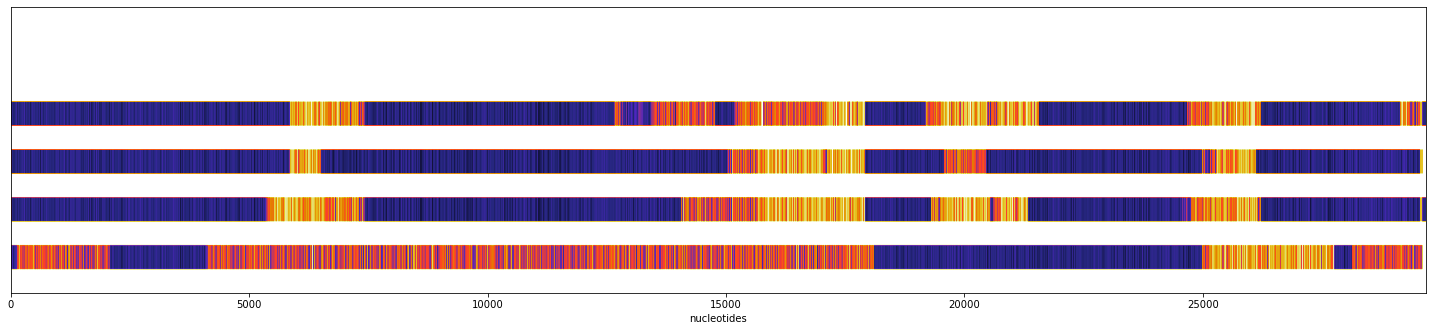

In [19]:
#if want a tile:
#plot_title=', '.join(x for x in FASTA_LIST)
plot_title=''
plot_blocked_seq(twod_borders_on_stack, name=OUT_PATH+f'{len(FASTA_LIST)}_{COV_NAME}_{ASM_CODE}_stiched_asm_seqs.png', title=plot_title)

Figure 2. (generation of Figure 1). In the figure above we can see 4 rows of nuclotide sequences. The rows show consensus sequences from assembly of SRA dataset NCBI accession SRR12464727 and SRR12432009

Blue=good coverage, red multiple empty read locations, yellow, poor reads-many empty

Order of rows as per cell below

In [36]:
FASTA_LIST

['RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_defaults.fa',
 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_k79_max.fa',
 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_mega_kstep10_nomercy.fa',
 'RmYN02_BetaCoV_bat_Yunnan_RmYN02_2019_coronaspades_default.fa']

In [20]:
missing_nns = np.argwhere(np.all(stacked[..., :] == 0, axis=0)).tolist()

In [21]:
len(missing_nns)

574

In [22]:
missing_nns = [item for sublist in missing_nns for item in sublist]

In [23]:
#S protein location specific to RaTG13
spike_seq_missing = [i for i in missing_nns if int(i) >= 21563 and int(i)<=25384 ]

In [24]:
len(spike_seq_missing)

77

In [25]:
def group(L):
    '''after https://stackoverflow.com/questions/2154249/identify-groups-of-continuous-numbers-in-a-list'''''
    first = last = L[0]
    for n in L[1:]:
        if n - 1 == last: # Part of the group, bump the end
            last = n
        else: # Not part of the group, yield current group and start a new
            yield first, last
            first = last = n
    yield first, last # Yield the last group

In [26]:
print (list(group(spike_seq_missing)))

[(24983, 24983), (24988, 24988), (24993, 24993), (24995, 24996), (24998, 24998), (25000, 25000), (25009, 25009), (25021, 25021), (25024, 25024), (25026, 25026), (25028, 25028), (25030, 25030), (25032, 25032), (25035, 25035), (25039, 25039), (25041, 25041), (25061, 25061), (25073, 25073), (25094, 25094), (25112, 25112), (25121, 25121), (25145, 25145), (25164, 25164), (25175, 25175), (25181, 25182), (25184, 25184), (25194, 25194), (25203, 25203), (25207, 25207), (25212, 25212), (25215, 25215), (25217, 25218), (25224, 25224), (25228, 25229), (25232, 25233), (25237, 25237), (25249, 25249), (25263, 25264), (25271, 25272), (25279, 25279), (25282, 25283), (25286, 25286), (25288, 25288), (25290, 25290), (25292, 25292), (25295, 25295), (25298, 25298), (25307, 25307), (25313, 25314), (25316, 25318), (25322, 25322), (25340, 25340), (25346, 25348), (25350, 25350), (25354, 25354), (25358, 25358), (25360, 25360), (25363, 25366), (25369, 25369), (25371, 25371), (25375, 25375)]


In [27]:
grouped_missing= list(group(missing_nns))

The list below shows tuples of (start, end) of gaps in coverage accross all the fasta inputs

In [28]:
grouped_missing

[(5861, 5861),
 (5873, 5873),
 (5876, 5876),
 (5881, 5881),
 (5889, 5889),
 (5892, 5892),
 (5899, 5899),
 (5901, 5901),
 (5904, 5904),
 (5906, 5906),
 (5913, 5913),
 (5915, 5915),
 (5917, 5917),
 (5926, 5926),
 (5931, 5931),
 (5934, 5934),
 (5940, 5940),
 (5946, 5946),
 (5958, 5958),
 (5967, 5967),
 (5969, 5970),
 (5976, 5976),
 (5990, 5990),
 (6004, 6004),
 (6013, 6013),
 (6017, 6017),
 (6022, 6022),
 (6024, 6024),
 (6033, 6033),
 (6037, 6037),
 (6060, 6060),
 (6067, 6067),
 (6072, 6072),
 (6075, 6075),
 (6085, 6085),
 (6097, 6097),
 (6099, 6099),
 (6117, 6117),
 (6126, 6126),
 (6129, 6129),
 (6141, 6141),
 (6153, 6153),
 (6159, 6159),
 (6169, 6169),
 (6181, 6181),
 (6191, 6191),
 (6195, 6195),
 (6199, 6200),
 (6211, 6211),
 (6213, 6213),
 (6215, 6215),
 (6228, 6228),
 (6234, 6235),
 (6247, 6248),
 (6252, 6252),
 (6268, 6268),
 (6273, 6273),
 (6275, 6275),
 (6283, 6284),
 (6287, 6288),
 (6317, 6318),
 (6320, 6320),
 (6322, 6323),
 (6326, 6326),
 (6328, 6328),
 (6330, 6330),
 (6349, 63

In [29]:
missing_nn_locations=[]
for g in grouped_missing:
    if g[0]==g[1]:
        missing_nn_locations.append(g[0])
    else:
        missing_nn_locations.append(g)

In [30]:
missing_nn_locations

[5861,
 5873,
 5876,
 5881,
 5889,
 5892,
 5899,
 5901,
 5904,
 5906,
 5913,
 5915,
 5917,
 5926,
 5931,
 5934,
 5940,
 5946,
 5958,
 5967,
 (5969, 5970),
 5976,
 5990,
 6004,
 6013,
 6017,
 6022,
 6024,
 6033,
 6037,
 6060,
 6067,
 6072,
 6075,
 6085,
 6097,
 6099,
 6117,
 6126,
 6129,
 6141,
 6153,
 6159,
 6169,
 6181,
 6191,
 6195,
 (6199, 6200),
 6211,
 6213,
 6215,
 6228,
 (6234, 6235),
 (6247, 6248),
 6252,
 6268,
 6273,
 6275,
 (6283, 6284),
 (6287, 6288),
 (6317, 6318),
 6320,
 (6322, 6323),
 6326,
 6328,
 6330,
 6349,
 6353,
 (6362, 6364),
 6370,
 6373,
 6382,
 6385,
 (6397, 6398),
 (6402, 6403),
 6408,
 6428,
 6431,
 6435,
 6438,
 6453,
 6457,
 6459,
 6476,
 15257,
 15295,
 15346,
 15349,
 15358,
 15365,
 15393,
 15395,
 15419,
 15436,
 15472,
 15526,
 15543,
 15547,
 15568,
 15630,
 15645,
 15654,
 (15660, 15661),
 15668,
 15675,
 15686,
 (15688, 15689),
 (15701, 15702),
 15706,
 15710,
 15717,
 15727,
 15743,
 15749,
 15752,
 15775,
 15791,
 15802,
 15816,
 15820,
 15860,
 

In [31]:
deltas=[]
for t in grouped_missing:
    deltas.append(1+t[1]-t[0])

In [32]:
#number of and legth of each gap (in NN)
len(deltas),deltas

(484,
 [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  1,
  1,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

<BarContainer object of 484 artists>

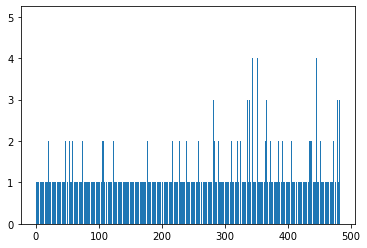

In [33]:
plt.bar(list(range(len(deltas))), deltas)

In [34]:
pct_missing = (len(missing_nns)/len(query_target_seq))%100

In [35]:
print(f'{pct_missing} from any assemby method')

0.01934548886117758 from any assemby method


### Summary

### References


Signus, J. Anomalous datasets reveal metagenomic fabrication pipeline that further questions the legitimacy of RaTG13 genome and the associated Nature paper. Preprint. https://vixra.org/abs/2010.0164

